In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# فصل ۲ — تبدیل داده و کُدگذاری
## درس ۱۳: ساخت خط لوله‌های پیش‌پردازش (انضباط Fit/Transform، خط لوله‌های ستونی)



### آنچه در این درس یاد می‌گیرید

در پایان این درس باید بتوانید:

- توضیح دهید چرا پیش‌پردازش باید فقط از داده‌های آموزش یاد گرفته شود و سپس بدون تغییر روی داده‌های اعتبارسنجی/آزمون اعمال شود.
- با `Pipeline` چند گام پیش‌پردازش و یک مدل را در قالب یک شیء واحد و ایمن زنجیره کنید.
- با `ColumnTransformer` پیش‌پردازش‌های متفاوت را به‌صورت ستونی روی ویژگی‌های عددی، دسته‌ای و متنی اعمال کنید.
- خطاهای رایج در خط لوله‌ها را عیب‌یابی کنید: ناسازگاری ابعاد، مسائل sparse/dense، مدیریت مقدارهای گمشده، و رهگیری نام ویژگی‌ها.
- اعتبارسنجی متقاطع و تنظیم ابرپارامترها را بدون نشت داده انجام دهید.

---

### چرا «خط لوله» لازم است؟

در یادگیری ماشین کلاسیک روی داده‌های جدولی، مدل معمولاً جدول خام را مستقیماً مصرف نمی‌کند. به‌جای آن، یک دنباله از تبدیل‌ها انجام می‌شود:

- پاک‌سازی (مقادیر گمشده، اصلاح نوع داده)،
- کُدگذاری (تبدیل دسته‌ای به عددی)،
- مقیاس‌بندی (استانداردسازی/نرمال‌سازی)،
- ساخت ویژگی (تعامل‌ها، تبدیل لگاریتمی، استخراج اجزای تاریخ/زمان)،
- کاهش بُعد (در صورت نیاز).

وسوسهٔ خطرناک این است که این تبدیل‌ها را «یک‌بار» روی کل داده انجام دهید و بعد داده را به آموزش/آزمون تقسیم کنید. این کار مهم‌ترین قانون را نقض می‌کند:

> **هر تبدیلی که پارامترهایش از داده یاد گرفته می‌شود، باید فقط روی دادهٔ آموزش fit شود.**

نمونه‌هایی از پارامترهای یادگرفته‌شده:

- میانگین و انحراف معیار برای استانداردسازی،
- نگاشت دسته به شاخص برای وان-هات،
- واژگان و وزن‌های IDF برای TF–IDF،
- آمارهای جایگذاری مقدار گمشده (میانه، پرتکرارترین)،
- مؤلفه‌های PCA.

اگر این پارامترها «دادهٔ آزمون» را هم ببینند، پیش‌پردازش به یک کانال پنهان تبدیل می‌شود که اطلاعاتی از آزمون به آموزش نشت می‌دهد.

---

### انضباط Fit/Transform به‌صورت یک گزارهٔ ریاضی

فرض کنید $D = \{(x_i, y_i)\}_{i=1}^n$ یک مجموعه‌داده باشد و آن را به آموزش و آزمون تقسیم کنیم:

$$D_{\text{train}} \cup D_{\text{test}} = D, \quad D_{\text{train}} \cap D_{\text{test}} = \emptyset.$$

یک گام پیش‌پردازش معمولاً دو عملیات دارد:

- **fit**: تخمین پارامترها $\theta$ از داده
- **transform**: اعمال پارامترها روی ورودی

به‌صورت صوری، یک تبدیل‌گر $T$ چنین القا می‌کند:

$$\theta = \mathrm{fit}(T, X_{\text{train}}), \qquad Z = \mathrm{transform}(T, X; \theta).$$

قانون این است:

$$Z_{\text{train}} = \mathrm{transform}(T, X_{\text{train}}; \theta), \quad
Z_{\text{test}} = \mathrm{transform}(T, X_{\text{test}}; \theta)$$

که در آن همان $\theta$ فقط از $X_{\text{train}}$ یاد گرفته شده است.

«خط لوله» این انضباط را بسته‌بندی می‌کند تا نقض آن به‌طور تصادفی سخت شود.

---

### مدل ذهنی سطح‌بالا

یک خط لوله را می‌توان به‌صورت ترکیب توابع دید:

$$f(x) = (M \circ T_k \circ \cdots \circ T_2 \circ T_1)(x)$$

که در آن $T_j$ها تبدیل‌های پیش‌پردازش و $M$ مدل نهایی است.

در زمان آموزش، هر $T_j$ فقط با استفاده از دادهٔ آموزش (و در داخل هر fold اعتبارسنجی متقاطع) fit می‌شود. دقیقاً به همین دلیل، خط لوله برای ارزیابی قابل اتکا ضروری است.


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt


In [3]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def read_csv(path, **kwargs):
    return pd.read_csv(path, **kwargs)



### یک نمایش سریع از نشت داده (استانداردسازیِ اشتباه)

استانداردسازی:

$$x' = \frac{x - \mu}{\sigma}$$

اگر $\mu$ و $\sigma$ را با استفاده از *کل* داده (آموزش + آزمون) تخمین بزنید، در واقع اطلاعات توزیع آزمون را در زمان آموزش استفاده کرده‌اید.

در کد زیر دو جریان کاری را مقایسه می‌کنیم:

1. **اشتباه**: fit کردن scaler قبل از تقسیم داده.
2. **درست**: قرار دادن scaler داخل یک Pipeline.

انتظار می‌رود جریان کاری «اشتباه» یک برآورد بیش‌ازحد خوش‌بینانه ایجاد کند—گاهی بسیار زیاد و گاهی کم، اما در هر حال در جهت غلط.


In [4]:
# Dataset: diabetes (binary classification)
path_diabetes = "../../../Datasets/Classification/diabetes.csv"
df = read_csv(path_diabetes)

X = df.drop(columns=["classification"])
y = df["classification"]

# Encode target as 0/1 for metrics
y01 = (y == "Diabetic").astype(int)

# Wrong workflow: scale before splitting (leaks test distribution into scaler)
scaler_wrong = StandardScaler()
X_wrong = scaler_wrong.fit_transform(X)

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X_wrong, y01, test_size=0.25, random_state=42, stratify=y01
)

clf = LogisticRegression(max_iter=2000)
clf.fit(Xw_train, yw_train)
pred_proba_wrong = clf.predict_proba(Xw_test)[:, 1]
pred_wrong = (pred_proba_wrong >= 0.5).astype(int)

acc_wrong = accuracy_score(yw_test, pred_wrong)
auc_wrong = roc_auc_score(yw_test, pred_proba_wrong)

# Correct workflow: scaler inside a Pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y01, test_size=0.25, random_state=42, stratify=y01
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)
pred_proba = pipe.predict_proba(X_test)[:, 1]
pred = (pred_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, pred_proba)

pd.DataFrame({
    "Workflow": ["Wrong (leakage)", "Correct (pipeline)"],
    "Accuracy": [acc_wrong, acc],
    "ROC-AUC": [auc_wrong, auc],
})


,Workflow,Accuracy,ROC-AUC
0,Wrong (leakage),0.734375,0.832
1,Correct (pipeline),0.734375,0.832



### درون‌مایهٔ خط لوله: هدایت پارامترها و «دو زیرخط»

هر گام خط لوله یک **نام** دارد. ابرپارامترها با الگوی زیر آدرس‌دهی می‌شوند:

`<step_name>__<parameter_name>`

مثال:

- `model__C` شدت منظم‌سازی در رگرسیون لجستیک را تنظیم می‌کند،
- `preprocess__cat__onehot__min_frequency` رفتار کُدگذار دسته‌ای را تنظیم می‌کند (اگر در نسخهٔ شما پشتیبانی شود).

این یک نکتهٔ ظاهری نیست؛ همین سازوکار است که تنظیم تو‌در‌تو را ممکن می‌کند.

---

### چرا نشت داده ارزیابی را خراب می‌کند (یک استدلال فشرده)

فرض کنید بعد از تبدیل ورودی‌ها با پارامترهای $\theta$ که از *کل* $X$ (شامل $X_{\text{test}}$) تخمین زده شده‌اند، روی $D_{\text{test}}$ ارزیابی کنید. در این صورت شما در حال اندازه‌گیریِ

$$\mathbb{E}_{(X,Y) \sim \mathcal{P}}[L(Y, f(X))]$$

برای یک خط لولهٔ آموزش‌دیده روی دادهٔ آموزش مستقل نیستید. بلکه عملکرد را **مشروط به همان آزمون مشخص** می‌سنجید، چون $\theta$ تابعی از $X_{\text{test}}$ است:

$$\theta = g(X_{\text{train}}, X_{\text{test}}).$$

بنابراین پیش‌بینی‌کنندهٔ مورد ارزیابی شما چنین است:

$$f_{\theta}(\cdot) = M(T(\cdot; \theta))$$

و $f_{\theta}$ به مجموعهٔ آزمونی که روی آن ارزیابی می‌کنید وابسته می‌شود. این وابستگی استقلالی را که باعث می‌شود خطای holdout یا cross-validation نمایندهٔ تعمیم باشد، نقض می‌کند.

خط لوله‌ها ساختار صحیح را برمی‌گردانند: هر fold با پارامترهایی تبدیل می‌شود که فقط از بخش آموزش همان fold یاد گرفته شده‌اند.

---

### گام‌های پیش‌پردازشی که باید داخل خط لوله باشند

1. **جایگذاری مقدار گمشده** (آمارها یاد گرفته می‌شوند)
2. **مقیاس‌بندی** (میانگین/واریانس یاد گرفته می‌شوند)
3. **کُدگذاری** (نگاشت دسته‌ها یاد گرفته می‌شود)
4. **بردارسازی متن** (واژگان و IDF یاد گرفته می‌شوند)
5. **کاهش بُعد** (ماتریس تصویرسازی یاد گرفته می‌شود)
6. **کُدگذارهای مبتنی بر هدف** (مستقیماً از $y$ یاد می‌گیرند و حساس‌تر هستند)

تبدیل‌های بدون حالت (مثلاً `np.log1p`، برش‌دادن، تبدیل واحد) را می‌توان بیرون یا داخل خط لوله اعمال کرد؛ اما معمولاً یکپارچه‌سازی همهٔ مراحل داخل یک خط لوله، تمیزتر و قابل نگهداری‌تر است.



### اعتبارسنجی متقاطع با خط لوله‌ها: چه چیزی تخمین زده می‌شود؟

در اعتبارسنجی متقاطع $K$-تایی، بارها روی $K-1$ fold آموزش می‌دهید و روی fold باقی‌مانده اعتبارسنجی می‌کنید. اگر $L$ یک تابع زیان باشد، برآورد CV چنین است:

$$\hat R_{\text{CV}} = \frac{1}{K} \sum_{k=1}^K \frac{1}{|\mathcal{I}_k|} \sum_{i \in \mathcal{I}_k} L\big(y_i, \hat y_i^{(-k)}\big)$$

که در آن $\hat y_i^{(-k)}$ پیش‌بینی نمونهٔ $i$ توسط مدلی است که بدون fold $k$ آموزش دیده است.

اگر پیش‌پردازش را بیرون از خط لوله انجام دهید، تبدیل قبلاً همهٔ foldها را دیده است؛ بنابراین $\hat y_i^{(-k)}$ دیگر حاصل مدلی نیست که واقعاً fold $k$ را ندیده باشد. خط لوله تضمین می‌کند که در هر fold:

- پارامترهای تبدیل فقط از بخش آموزش همان fold تخمین زده شوند،
- و fold اعتبارسنجی با همان پارامترها تبدیل شود.

این یکی از پراثرترین عادت‌ها در یادگیری ماشین کاربردی است.


In [5]:
# Cross-validation with a pipeline: preprocessing is refit inside each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y01, cv=cv, scoring="roc_auc")
pd.DataFrame({"fold_roc_auc": scores, "mean": [scores.mean()]*len(scores)})


,fold_roc_auc,mean
0,0.816852,0.830388
1,0.869259,0.830388
2,0.841111,0.830388
3,0.808868,0.830388
4,0.815849,0.830388



### ترتیب گام‌های پیش‌پردازش (دل‌بخواهی نیست)

بسیاری از تبدیل‌ها با هم جابجاپذیر نیستند. یک ترتیب پیش‌فرض امن برای دادهٔ عددی:

1. **تبدیل نوع / پارس‌کردن** (رشته به عدد/تاریخ)
2. **جایگذاری مقدار گمشده**
3. **مدیریت دورافتاده‌ها** (اختیاری، اغلب با مقیاس‌گرهای مقاوم)
4. **مقیاس‌بندی**
5. **ساخت ویژگی** (چندجمله‌ای/تعامل، تبدیل لگاریتمی)
6. **مدل**

چرا قبل از مقیاس‌بندی جایگذاری می‌کنیم؟ چون مقیاس‌گر باید در همهٔ ردیف‌ها مقدار عددی داشته باشد.

یک imputer میانه را چنین تخمین می‌زند:

$$\tilde x_j = \mathrm{median}(\{x_{ij}: i \in D_{\text{train}}\})$$

و برای هر ویژگی $j$، مقادیر گمشدهٔ $x_{ij}$ را با $\tilde x_j$ جایگزین می‌کند.

اگر قبل از جایگذاری مقیاس‌بندی کنید، مقادیر گمشده منتقل می‌شوند و بسیاری از مدل‌ها شکست می‌خورند.

---

### رانش طرح‌واره (Schema drift): چرا انتخاب ستون باید صریح باشد

در نوت‌بوک‌ها انتخاب ستون با dtype رایج است:

- عددی: `dtype_include=np.number`
- دسته‌ای: «بقیه»

این روش راحت است، اما در عمل ممکن است رانش رخ دهد:

- ستونی که باید عددی باشد به‌دلیل مشکل پارس به رشته برسد،
- دسته‌های جدیدی ظاهر شوند که در آموزش دیده نشده‌اند،
- یک ستون تغییر نام بدهد یا حذف شود.

شیوه‌های مهندسی برای کاهش غافلگیری:

- فهرست ستون‌های هر بلوک را صریح نگه دارید،
- ستون‌ها و dtypeهای مورد انتظار را در زمان اجرا اعتبارسنجی کنید،
- برای وان-هات `handle_unknown="ignore"` بگذارید (در بالا انجام شده)،
- در `ColumnTransformer` دربارهٔ `remainder="drop"` یا `remainder="passthrough"` آگاهانه تصمیم بگیرید.

خط لوله جای مناسبی برای متمرکز کردن این کنترل‌هاست.



### ColumnTransformer: تبدیل جدول ناهمگون به ماتریس عددی

وان-هات یک دستهٔ $c$ را به یک بردار پایه $e_j$ نگاشت می‌کند:

$$\text{onehot}(c) = e_{\pi(c)}, \quad e_j \in \{0,1\}^m$$

که در آن $\pi$ نگاشت دسته به شاخص است و هنگام `fit` یاد گرفته می‌شود.

برای جدولی با بلوک عددی $X_n \in \mathbb{R}^{n \times p}$ و بلوک دسته‌ای $X_c$ با بُعد گسترش‌یافتهٔ کل $q$، ماتریس طراحیِ تبدیل‌شده چنین است:

$$Z = [\, Z_n \; \; Z_c \,] \in \mathbb{R}^{n \times (p+q)}.$$

`ColumnTransformer` با اعمال خط لولهٔ هر بلوک به‌صورت موازی و سپس الحاق خروجی‌ها، $Z$ را می‌سازد.

---

### خروجی dense در برابر sparse (پیامدهای عملی)

وان-هات معمولاً یک ماتریس sparse می‌سازد، چون اکثر اندیکاتورها صفر هستند. بسیاری از مدل‌ها در scikit-learn ورودی sparse را مستقیم می‌پذیرند (مدل‌های خطی، SVM خطی، SGD)، اما برخی مدل‌ها به آرایهٔ dense نیاز دارند.

دو الگوی رایج:

- همه‌چیز را sparse نگه دارید و از مدل‌های سازگار با sparse استفاده کنید.
- فقط وقتی ماتریس خیلی بزرگ نیست به dense تبدیل کنید (خطر انفجار حافظه).

برای مقیاس‌بندی دادهٔ sparse، کم‌کردن میانگین امکان‌پذیر نیست (ماتریس را dense می‌کند). به همین دلیل گاهی می‌بینید:

- `StandardScaler(with_mean=False)` برای بلوک‌های sparse.

در مثال رگرسیون مختلط، بلوک عددی dense و بلوک دسته‌ای sparse است و `ColumnTransformer` الحاق را مدیریت می‌کند.


### مثال رگرسیون چندنوعی (عدد + دسته‌ای)

اکنون یک خط لولهٔ پیش‌پردازش ستونی و یک مدل رگرسیون را روی مجموعه‌دادهٔ قیمت خانه‌ها می‌سازیم.


In [6]:
# Dataset: house prices (regression with mixed types)
path_house = "../../../Datasets/Regression/house-prices.csv"
house = read_csv(path_house)

Xh = house.drop(columns=["Price"])
yh = house["Price"].astype(float)

num_sel = make_column_selector(dtype_include=np.number)
cat_sel = make_column_selector(dtype_exclude=np.number)

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, num_sel),
    ("cat", categorical_pipeline, cat_sel)
])

reg = Ridge(alpha=1.0, random_state=42)

reg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", reg)
])

cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = -cross_val_score(reg_pipe, Xh, yh, cv=cv_reg, scoring="neg_root_mean_squared_error")

pd.DataFrame({"fold_RMSE": rmse_scores, "mean_RMSE": [rmse_scores.mean()]*len(rmse_scores)})


,fold_RMSE,mean_RMSE
0,10647.431875,9984.70284
1,9271.887576,9984.70284
2,12038.205273,9984.70284
3,8299.623666,9984.70284
4,9666.365810,9984.70284



### رهگیری نام ویژگی‌ها بعد از وان-هات

وقتی ویژگی‌های دسته‌ای را وان-هات می‌کنید، تعداد ستون‌ها زیاد می‌شود و نگاشت ستون‌های خروجی به معنای اولیه ممکن است گم شود.

برای تفسیرپذیری و عیب‌یابی، scikit-learn تابع `get_feature_names_out` را فراهم کرده است. در `ColumnTransformer` می‌توانید کُدگذار fit‌شده را استخراج کنید و نام‌های گسترش‌یافته را بازیابی کنید.

این کار به‌ویژه زمانی مهم است که:

- می‌خواهید ضرایب مدل‌های خطی را بررسی کنید،
- می‌خواهید اهمیت ویژگی‌ها (Permutation Importance) را محاسبه کنید،
- نیاز به توضیح‌های قابل ممیزی دارید.


In [7]:
# Inspect feature names after ColumnTransformer (useful for debugging and interpretability)
reg_pipe.fit(Xh, yh)
pre = reg_pipe.named_steps["preprocess"]

num_features = list(pre.transformers_[0][2])
cat_features = list(pre.transformers_[1][2])

ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_ohe_names = list(ohe.get_feature_names_out(cat_features))

all_feature_names = list(num_features) + cat_ohe_names
pd.Series(all_feature_names).head(25)


0                  Home
1                  SqFt
2              Bedrooms
3             Bathrooms
4                Offers
5              Brick_No
6             Brick_Yes
7     Neighborhood_East
8    Neighborhood_North
9     Neighborhood_West
dtype: object


### تنظیم ابرپارامترها روی خط لوله‌ها

یک اشتباه رایج این است که مدل را روی ویژگی‌های پیش‌پردازش‌شده‌ای تنظیم کنیم که توسط تبدیل‌گری ساخته شده‌اند که روی کل داده fit شده است. وقتی تبدیل‌گر داخل خط لوله باشد، `GridSearchCV` (یا `RandomizedSearchCV`) از این خطا جلوگیری می‌کند.

به‌صورت مفهومی، حلقهٔ جستجو این کارها را تکرار می‌کند:

1. انتخاب ابرپارامترها،
2. اجرای cross-validation،
3. در هر fold: fit پیش‌پردازش روی آموزش fold، transform آموزش و اعتبارسنجی fold، fit مدل، و امتیازدهی روی اعتبارسنجی fold.

این روش برآوردی بسیار واقع‌گرایانه‌تر از «یک‌بار پیش‌پردازش، سپس جستجو» می‌دهد.


In [8]:
# Hyperparameter tuning without leakage: GridSearchCV wraps the pipeline
param_grid = {
    "model__alpha": [0.1, 1.0, 10.0, 100.0],
    "preprocess__num__scaler__with_mean": [True],  # numeric block is dense, OK
}

search = GridSearchCV(
    reg_pipe,
    param_grid=param_grid,
    cv=cv_reg,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

search.fit(Xh, yh)
pd.DataFrame({
    "best_alpha": [search.best_params_["model__alpha"]],
    "best_cv_RMSE": [-search.best_score_],
})


,best_alpha,best_cv_RMSE
0,0.1,9972.637062



### جدول‌های عمدتاً دسته‌ای: کُدگذاری و انتخاب مدل

برخی مجموعه‌داده‌ها عمدتاً دسته‌ای هستند. در این حالت‌ها:

- وان-هات یک خط پایهٔ استاندارد است،
- دسته‌های نادر می‌توانند ماتریس sparse بسیار عریض تولید کنند،
- مدل‌های خطی اغلب روی ویژگی‌های وان-هات sparse عملکرد خوبی دارند.

پیچ‌های تنظیم مهم:

- `handle_unknown="ignore"` برای جلوگیری از خطا روی دسته‌های دیده‌نشده،
- جایگذاری برای مقادیر گمشدهٔ دسته‌ای (پرتکرارترین یا یک توکن ثابت),
- شدت منظم‌سازی در مدل خطی پایین‌دستی.

این موضوع را با مجموعه‌دادهٔ `drug200.csv` نشان می‌دهیم.


In [9]:
# Dataset: drug200 (categorical-heavy classification)
path_drug = "../../../Datasets/Classification/drug200.csv"
drug = read_csv(path_drug)

Xd = drug.drop(columns=["Drug"])
yd = drug["Drug"]

num_cols = Xd.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in Xd.columns if c not in num_cols]

pre_d = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

clf_pipe = Pipeline([
    ("preprocess", pre_d),
    ("model", LogisticRegression(max_iter=5000))
])

cv_d = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = cross_val_score(clf_pipe, Xd, yd, cv=cv_d, scoring="accuracy")
pd.DataFrame({"fold_accuracy": acc_scores, "mean": [acc_scores.mean()]*len(acc_scores)})


,fold_accuracy,mean
0,0.975,0.955
1,1.000,0.955
2,0.950,0.955
3,0.950,0.955
4,0.900,0.955



### پیش‌پردازش متن در خط لولهٔ ستونی (TF–IDF)

TF–IDF متن خام را به ویژگی‌های عددی تبدیل می‌کند. برای واژهٔ $t$ در سند $d$:

- بسامد واژه: $\mathrm{tf}(t,d)$
- بسامد سند: $\mathrm{df}(t)$ (تعداد اسنادی که واژه را دارند)

یک فرم رایج:

$$\mathrm{idf}(t) = \log\left(\frac{N+1}{\mathrm{df}(t)+1}\right) + 1$$

و

$$\mathrm{tfidf}(t,d) = \mathrm{tf}(t,d) \cdot \mathrm{idf}(t).$$

هم واژگان و هم آمارهای IDF هنگام `fit` یاد گرفته می‌شوند، بنابراین TF–IDF باید داخل خط لوله باشد تا نشت داده رخ ندهد.

---

### تفسیر مثال شکایت‌های مصرف‌کننده

در این مثال یک خط لولهٔ واحد می‌سازیم که:

- روایت‌های گمشده را به رشتهٔ خالی جایگزین می‌کند،
- روایت‌ها را با TF–IDF (یک‌واژه‌ای و دو‌واژه‌ای) بردارسازی می‌کند،
- ستون‌های ساخت‌یافتهٔ دسته‌ای را وان-هات می‌کند،
- و یک دسته‌بند را آموزش می‌دهد.

این یک الگوی استاندارد در محیط‌های عملیاتی است: یک شیء واحد که می‌توان آن را `fit` کرد، `predict` گرفت، اعتبارسنجی کرد و سریال‌سازی نمود.


In [10]:
# Dataset: Consumer complaints (text + structured columns)
path_complaints = "../../../Datasets/Clustering/ConsumerComplaints.csv"

usecols = [
    "Product Name",
    "Issue",
    "Company",
    "State Name",
    "Consumer Complaint Narrative",
    "Company Response to Consumer",
    "Timely Response",
    "Consumer Disputed",
]

complaints = read_csv(path_complaints, usecols=usecols, nrows=8000, low_memory=False)

# Define a binary target: whether consumer disputed the outcome
complaints = complaints.dropna(subset=["Consumer Disputed"])
ytext = (complaints["Consumer Disputed"].astype(str).str.strip().str.lower() == "yes").astype(int)

Xtext = complaints.drop(columns=["Consumer Disputed"])

text_cols = ["Product Name", "Issue", "Consumer Complaint Narrative"]
cat_cols = [c for c in Xtext.columns if c not in text_cols]
def join_text_columns(X):
    """
    Join multiple text-like columns into a single 1D array of documents.
    ColumnTransformer provides 2D arrays/dataframes; vectorizers expect 1D strings.
    """
    if isinstance(X, pd.DataFrame):
        df = X
    else:
        df = pd.DataFrame(np.asarray(X))
    return df.fillna("").astype(str).agg(" ".join, axis=1)

text_pipeline = Pipeline([
    ("join", FunctionTransformer(join_text_columns, validate=False)),
    ("tfidf", TfidfVectorizer(min_df=1, ngram_range=(1, 2)))
])

pre_text = ColumnTransformer([
    ("text", text_pipeline, text_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

text_clf = LogisticRegression(max_iter=5000)

pipe_text = Pipeline([
    ("preprocess", pre_text),
    ("model", text_clf)
])

cv_text = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = cross_val_score(pipe_text, Xtext, ytext, cv=cv_text, scoring="roc_auc")
pd.DataFrame({"fold_roc_auc": auc_scores, "mean": [auc_scores.mean()]*len(auc_scores)})


,fold_roc_auc,mean
0,0.586768,0.58082
1,0.585495,0.58082
2,0.589274,0.58082
3,0.578170,0.58082
4,0.564396,0.58082



### تبدیل‌گرهای سفارشی (وقتی ابزارهای آماده کافی نیستند)

بسیاری از نیازهای پیش‌پردازش، دامنه‌محور هستند:

- پارس‌کردن زمان و استخراج الگوهای فصلی،
- تبدیل واحدها،
- ساخت نسبت‌ها و تعامل‌ها،
- اعمال تبدیل‌های تک‌سویی (monotonic).

اگر یک تبدیل‌گر با `fit` و `transform` پیاده‌سازی کنید، با خط لوله سازگار می‌شود.

در مثال زمین‌لرزه:

1. `date` + `time` را به زمان‌مُهر تبدیل می‌کنیم.
2. اجزای تقویمی را استخراج می‌کنیم.
3. برای ساعتِ روز کُدگذاری چرخه‌ای اضافه می‌کنیم:

$$\mathrm{hour\_sin} = \sin\left(\frac{2\pi h}{24}\right), \quad
\mathrm{hour\_cos} = \cos\left(\frac{2\pi h}{24}\right).$$

کُدگذاری چرخه‌ای ناپیوستگی بین 23:00 و 00:00 را حذف می‌کند.

---

### FunctionTransformer برای تبدیل‌های بدون حالت

اگر می‌خواهید سریع یک تبدیل بدون ساخت کلاس بسازید، از `FunctionTransformer` استفاده کنید. مثلاً تبدیل لگاریتمی:

$$x' = \log(1+x)$$

را می‌توان با `FunctionTransformer(np.log1p)` نمایش داد.

در عمل، گام‌های نام‌دار و واضح را ترجیح دهید؛ خوانایی و قابلیت عیب‌یابی بخشی از کیفیت مهندسی است.


In [11]:
# Custom transformer example: extracting cyclic time features from earthquake date/time
path_quake = "../../../Datasets/Regression/earthquake.csv"
quake = read_csv(path_quake)

# Predict magnitude from location + depth + time features
yq = quake["magnitude"].astype(float)
Xq = quake.drop(columns=["magnitude"])

class DateTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, date_col="date", time_col="time"):
        self.date_col = date_col
        self.time_col = time_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        dt = pd.to_datetime(X[self.date_col].astype(str) + " " + X[self.time_col].astype(str), errors="coerce")

        # Basic components
        X["year"] = dt.dt.year.fillna(0).astype(int)
        X["month"] = dt.dt.month.fillna(0).astype(int)
        X["day"] = dt.dt.day.fillna(0).astype(int)
        X["hour"] = dt.dt.hour.fillna(0).astype(int)

        # Cyclic encoding for hour-of-day
        h = X["hour"].astype(float)
        X["hour_sin"] = np.sin(2 * np.pi * h / 24.0)
        X["hour_cos"] = np.cos(2 * np.pi * h / 24.0)

        return X.drop(columns=[self.date_col, self.time_col])

pre_q = Pipeline([
    ("dt", DateTimeFeatures(date_col="date", time_col="time")),
    ("ct", ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]),
         make_column_selector(dtype_include=np.number))
    ]))
])

reg_q = Ridge(alpha=1.0, random_state=42)

pipe_q = Pipeline([
    ("preprocess", pre_q),
    ("model", reg_q)
])

cv_q = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_q = -cross_val_score(pipe_q, Xq, yq, cv=cv_q, scoring="neg_root_mean_squared_error")
pd.DataFrame({"fold_RMSE": rmse_q, "mean_RMSE": [rmse_q.mean()]*len(rmse_q)})


,fold_RMSE,mean_RMSE
0,0.741367,0.741874
1,0.745375,0.741874
2,0.741413,0.741874
3,0.740502,0.741874
4,0.740714,0.741874



### چک‌لیست عیب‌یابی و اعتبارسنجی

وقتی خط لوله‌ها درست کار نمی‌کنند، حالت‌های شکست معمولاً قابل پیش‌بینی هستند. یک چک‌لیست منظم زمان را حفظ می‌کند:

**1) طرح‌واره (schema) را زود بررسی کنید**
- نام ستون‌ها درست است؟
- ستون‌های عددی واقعاً عددی هستند (`dtype`)؟
- مقادیر گمشده به‌صورت سازگار نمایش داده شده‌اند؟

**2) خروجی پیش‌پردازش را اعتبارسنجی کنید**
- ابعاد `transform` را چک کنید: تعداد ردیف‌ها باید برابر بماند.
- مشخص کنید خروجی sparse است یا dense.
- برای چند ردیف، مقادیر تبدیل‌شده را نمونه‌برداری و بررسی کنید.

**3) مراقب نشت دادهٔ ضمنی باشید**
- آیا قبل از split روی کل داده `fit` انجام شده است؟
- آیا کُدگذار وابسته به هدف بدون cross-fitting استفاده شده است؟
- آیا ویژگی‌ای دارید که از زمان‌های بعد از وقوع نتیجه ساخته شده باشد؟

**4) پروتکل ارزیابی را تأیید کنید**
- از خط لوله داخل `cross_val_score` / `GridSearchCV` استفاده کنید.
- برای طبقه‌بندی، در صورت نیاز stratify کنید.
- تصادفی‌بودن را ثابت کنید (`random_state`) برای بازتولیدپذیری.

**5) بهداشت تفسیرپذیری**
- نام ویژگی‌ها را رهگیری کنید (`get_feature_names_out`) در وان-هات.
- فهرست ستون‌های ورودی هر بلوک را صریح نگه دارید تا drift خاموش رخ ندهد.


In [12]:
# Debugging tools: check intermediate outputs
pipe_text.fit(Xtext, ytext)

tfidf = pipe_text.named_steps["preprocess"].named_transformers_["text"].named_steps["tfidf"]
vocab_size = len(tfidf.vocabulary_)

pd.Series(list(tfidf.vocabulary_.keys())[:25], name="sample_terms"), vocab_size


(0          consumer
 1              loan
 2          managing
 3               the
 4                or
 5             lease
 6     consumer loan
 7     loan managing
 8      managing the
 9          the loan
 10          loan or
 11         or lease
 12             bank
 13          account
 14          service
 15            using
 16            debit
 17              atm
 18             card
 19     bank account
 20       account or
 21       or service
 22    service using
 23      using debit
 24         debit or
 Name: sample_terms, dtype: object,
 419)


### شهود بصری: مقیاس‌بندی با یک ویژگی چه می‌کند؟

مقیاس‌بندی فقط «کوچک‌کردن اعداد» نیست؛ برای بسیاری از مدل‌ها هندسهٔ مسئله را تغییر می‌دهد.

مثلاً در رگرسیون لجستیک، مسئلهٔ بهینه‌سازی اغلب یک جریمهٔ $\ell_2$ دارد:

$$\min_w \; \sum_{i=1}^n \log\big(1+\exp(-y_i w^\top x_i)\big) + \lambda \|w\|_2^2.$$

اگر یک ویژگی مقیاس بسیار بزرگ‌تری داشته باشد، می‌تواند گرادیان را غالب کند و اثر منظم‌سازی را مخدوش کند، مگر اینکه مقیاس‌بندی انجام شود.

هیستوگرام زیر توزیع خام یک ویژگی و نسخهٔ استانداردشده را مقایسه می‌کند.


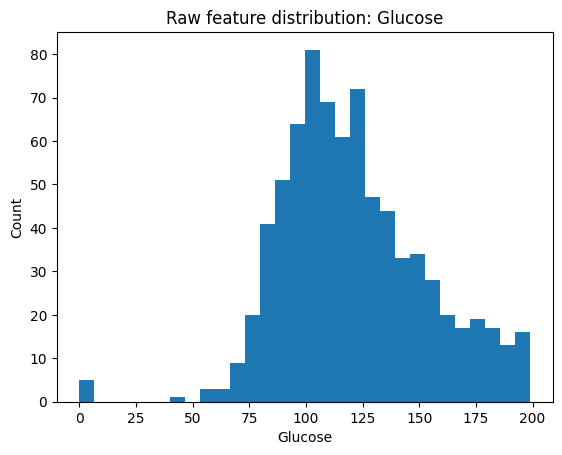

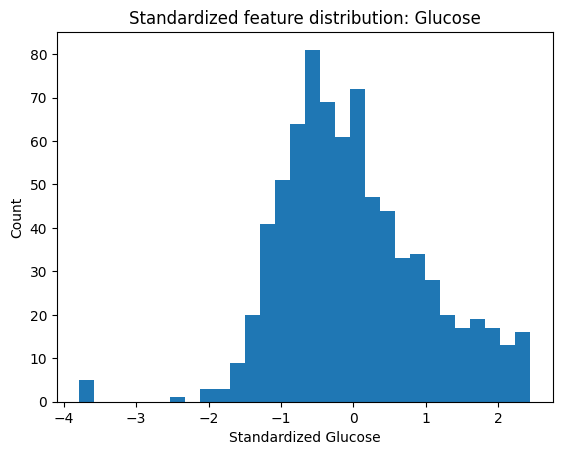

In [13]:
# Visualizing a single transformation: standardization effect on one feature
feature = "Glucose"
x_raw = df[feature].astype(float).to_numpy()

sc = StandardScaler()
x_scaled = sc.fit_transform(x_raw.reshape(-1, 1)).ravel()

plt.figure()
plt.hist(x_raw, bins=30)
plt.title("Raw feature distribution: Glucose")
plt.xlabel("Glucose")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(x_scaled, bins=30)
plt.title("Standardized feature distribution: Glucose")
plt.xlabel("Standardized Glucose")
plt.ylabel("Count")
plt.show()



### ذخیره‌سازی خط لولهٔ fit‌شده (یک آرتیفکت برای پیش‌پردازش + مدل)

وقتی روی یک خط لولهٔ fit‌شده `joblib.dump` را اجرا می‌کنید، این موارد ذخیره می‌شوند:

- پارامترهای پیش‌پردازش fit‌شده،
- پارامترهای مدل fit‌شده،
- و سیم‌کشی دقیق بین آن‌ها.

این ساده‌ترین مسیر برای استنتاج سازگار در آینده است.

در یک مخزن آموزشی گیت‌هاب، معمولاً بهتر است سریال‌سازی را به‌عنوان یک تکنیک **نشان دهید**، اما فایل‌های باینری بزرگ را بدون برنامهٔ مشخص MLOps در مخزن commit نکنید (مثلاً Git LFS یا رجیستری مدل).



In [14]:
# Serialization: save a fully-fitted pipeline (preprocessing + model)
import joblib

pipe.fit(X_train, y_train)
joblib.dump(pipe, "Chapter2_Lesson13_diabetes_pipeline.joblib")


['Chapter2_Lesson13_diabetes_pipeline.joblib']


### سازگاری آموزش/خدمت‌دهی (چرا یک خط لولهٔ سریال‌شده مهم است)

یک حالت شکست پرتکرار در سامانه‌های واقعی «ناهمخوانی آموزش و خدمت‌دهی» است:

- کد آموزش پیش‌پردازش نسخهٔ A را اعمال می‌کند.
- کد خدمت‌دهی نسخهٔ B را اعمال می‌کند (یا یک گام را فراموش می‌کند).
- عملکرد مدل در تولید سقوط می‌کند.

اگر یک شیء واحد شامل پیش‌پردازش و مدل را سریال‌سازی کنید:

- آموزش و استنتاج دقیقاً از یک تبدیل استفاده می‌کنند،
- نسخه‌بندی ساده‌تر می‌شود (یک آرتیفکت),
- ممیزی‌ها آسان‌تر می‌شوند («دقیقاً چه چیزی این پیش‌بینی را تولید کرد؟»).

به همین دلیل حتی در کارهای دانشگاهی نیز بهتر است خط لوله را یک آرتیفکت درجه‌یک بدانید.

---

### کش‌کردن تبدیل‌های پرهزینه (اختیاری)

برخی تبدیل‌ها پرهزینه‌اند (بردارسازی متن، وان-هات بزرگ). `Pipeline` امکان کش‌کردن با `memory=...` (joblib) را می‌دهد. در آزمایش‌های طولانی، کش می‌تواند زمان را کاهش دهد. فقط وقتی استفاده کنید که ورودی‌ها پایدار باشند و پیامدها را بدانید.

---

### جمع‌بندی

- همهٔ گام‌های یادگرفتنی را داخل خط لوله قرار دهید.
- برای جدول‌های چندنوعی از `ColumnTransformer` استفاده کنید.
- اعتبارسنجی را روی خود خط لوله انجام دهید.
- تنظیم ابرپارامترها را با `GridSearchCV` حول خط لوله انجام دهید.
- خط لولهٔ fit‌شده را برای استنتاج بازتولیدپذیر سریال‌سازی کنید.



### تمرین‌ها (پیشنهادی)

1. **آزمون نشت داده (diabetes)**
   - یک گام imputer اضافه کنید و عمداً آن را بیرون از خط لوله fit کنید.
   - تغییر ROC–AUC در cross-validation را اندازه بگیرید.
   - توضیح دهید چرا این تفاوت رخ می‌دهد.

2. **رگرسیون مقاوم با نوع‌های مختلط (house prices)**
   - `Ridge` را با یک مدل درختی (مثلاً `RandomForestRegressor`) جایگزین کنید.
   - ببینید کدام گام‌های پیش‌پردازش کم‌اهمیت‌تر می‌شوند و چرا.
   - RMSE و زمان آموزش را مقایسه کنید.

3. **ویژگی‌های دسته‌ای با تعداد دستهٔ زیاد**
   - در یک مجموعه‌داده با دسته‌های زیاد، این گزینه‌ها را مقایسه کنید:
     - وان-هات،
     - هش‌کردن (مثلاً با `FeatureHasher` یا مشابه)،
     - گروه‌بندی دسته‌های نادر (اگر پشتیبانی شود).
   - عملکرد و مصرف حافظه را ارزیابی کنید.

4. **قابل‌حمل‌بودن خط لوله**
   - یک خط لوله را fit کنید، با `joblib` ذخیره کنید، دوباره بارگذاری کنید و روی یک نمونهٔ نگه‌داشته‌شده `predict` بگیرید.
   - تأیید کنید که خروجی‌ها دقیقاً یکسان هستند.

5. **ساخت تبدیل‌گر خودتان**
   - یک تبدیل‌گر پیاده‌سازی کنید که:
     - یک ویژگی نسبت بسازد (مثلاً $\frac{\text{Insulin}}{\text{Glucose}+\epsilon}$)،
     - و یک نسخهٔ clipped از BMI ایجاد کند.
   - آن را در خط لوله قرار دهید و با cross-validation اعتبارسنجی کنید.
